In [1]:
from __future__ import print_function

from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
batch_size = 128
nb_classes = 10

In [3]:
# load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')
X_train /= 255.0
X_test /= 255.0

# convert class vectors to 1-of-K format
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [4]:
print('train samples: ', X_train.shape)
print('test samples: ', X_test.shape)

train samples:  (60000, 784)
test samples:  (10000, 784)


## Full Connected Layer

In [6]:
in_layer = Input((784,))
hidden = Dense(512, activation = 'relu')(in_layer)
hidden = Dense(512, activation = 'relu')(hidden)
output = Dense(10, activation = 'softmax')(hidden)

In [7]:
model = Model(input=in_layer, output=output)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [8]:
hist = model.fit(X_train, y_train,
                 batch_size=batch_size,
                 verbose=1,
                 nb_epoch=100,
                 validation_split=0.1,
                 callbacks=[early_stopping]
                 )

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 21s - loss: 0.2392 - acc: 0.9257 - val_loss: 0.0909 - val_acc: 0.9722
Epoch 2/100
54000/54000 [==============================] - 20s - loss: 0.0867 - acc: 0.9734 - val_loss: 0.0702 - val_acc: 0.9787
Epoch 3/100
54000/54000 [==============================] - 21s - loss: 0.0551 - acc: 0.9829 - val_loss: 0.0871 - val_acc: 0.9777
Epoch 4/100
54000/54000 [==============================] - 18s - loss: 0.0387 - acc: 0.9878 - val_loss: 0.0782 - val_acc: 0.9805
Epoch 5/100
54000/54000 [==============================] - 15s - loss: 0.0296 - acc: 0.9907 - val_loss: 0.0904 - val_acc: 0.9797


In [9]:
# evaluate
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

 9984/10000 [============================>.] - ETA: 0sTest loss: 0.0970026747965
Test accuracy: 0.9763


In [10]:
print (np.argmax(model.predict(X_test[:10]),axis=1))
print (np.argmax(y_test[:10],axis=1))

[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


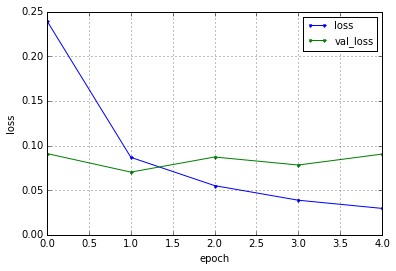

In [11]:
# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Autoencoder

In [12]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [13]:
autoencoder = Model(input=input_img, output=decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [14]:
ae = autoencoder.fit(X_train, X_train,
                 batch_size=batch_size,
                 verbose=1,
                 nb_epoch=30,
                 validation_split=0.1
                 )

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 17s - loss: 0.3178 - val_loss: 0.2561
Epoch 2/30
54000/54000 [==============================] - 17s - loss: 0.2445 - val_loss: 0.2351
Epoch 3/30
54000/54000 [==============================] - 17s - loss: 0.2223 - val_loss: 0.2096
Epoch 4/30
54000/54000 [==============================] - 21s - loss: 0.2035 - val_loss: 0.1975
Epoch 5/30
54000/54000 [==============================] - 26s - loss: 0.1942 - val_loss: 0.1902
Epoch 6/30
54000/54000 [==============================] - 21s - loss: 0.1864 - val_loss: 0.1822
Epoch 7/30
54000/54000 [==============================] - 25s - loss: 0.1789 - val_loss: 0.1729
Epoch 8/30
54000/54000 [==============================] - 24s - loss: 0.1704 - val_loss: 0.1652
Epoch 9/30
54000/54000 [==============================] - 23s - loss: 0.1647 - val_loss: 0.1617
Epoch 10/30
54000/54000 [==============================] - 23s - loss: 0.1602 - val_los

/Users/sho/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


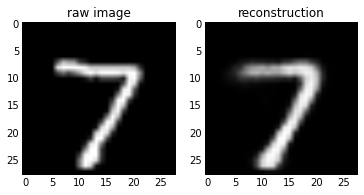

In [15]:
plt.subplot(121)
plt.imshow(X_test[0].reshape(28,28),cmap='gray')
plt.title("raw image")
plt.subplot(122)
plt.imshow(autoencoder.predict(X_test[:1]).reshape(28,28),cmap='gray')
plt.title("reconstruction")
plt.legend()
plt.show()

In [16]:
encoder = Model(input=input_img, output=encoded)

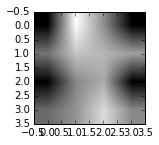

In [17]:
encoded_imgs = encoder.predict(X_test[:1])
plt.figure(figsize=(2,2))
plt.imshow(encoded_imgs.reshape(4,4),cmap='gray')

## Variational AutoEncoder

In [61]:
nb_epoch=100
batch_size=50
z_dim =2

In [62]:
x = Input(shape=(784,))
hidden = Dense(500, activation='softplus')(x)
hidden2 = Dense(500, activation='softplus')(hidden)
z_mean = Dense(z_dim)(hidden2)
z_log_sigma = Dense(z_dim)(hidden2)

In [63]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(z_dim,), mean=0., std=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [64]:
z = Lambda(sampling, output_shape=(z_dim,))([z_mean, z_log_sigma])

In [65]:
decoder_h = Dense(500, activation='softplus')
decoder_h2 = Dense(500, activation='softplus')
decoder_mean = Dense(784, activation='sigmoid')
h_decoded = decoder_h(z)
h_decoded2 = decoder_h2(h_decoded)
x_decoded_mean = decoder_mean(h_decoded2)

In [66]:
def vae_loss(x, x_decoded_mean):
    #reconstr_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    reconst_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    latent_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return reconst_loss + latent_loss

In [67]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='adam', loss=vae_loss)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

In [68]:
vae.reset_states()

In [69]:
z_in = Input(shape=(z_dim,))
_h_decoded = decoder_h(z_in)
_x_decoded_mean = decoder_mean(_h_decoded)

In [70]:
decoder= Model(input=z_in, output=_x_decoded_mean)

In [71]:
hist_vae = vae.fit(X_train, X_train,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        shuffle = True,
        validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 89s - loss: 0.2789 - val_loss: 0.2635
Epoch 2/100
60000/60000 [==============================] - 88s - loss: 0.2638 - val_loss: 0.2631
Epoch 3/100
60000/60000 [==============================] - 92s - loss: 0.2635 - val_loss: 0.2628
Epoch 4/100
60000/60000 [==============================] - 84s - loss: 0.2633 - val_loss: 0.2632
Epoch 5/100
60000/60000 [==============================] - 91s - loss: 0.2632 - val_loss: 0.2626
Epoch 6/100
60000/60000 [==============================] - 86s - loss: 0.2631 - val_loss: 0.2626
Epoch 7/100
60000/60000 [==============================] - 78s - loss: 0.2630 - val_loss: 0.2628
Epoch 8/100
60000/60000 [==============================] - 90s - loss: 0.2630 - val_loss: 0.2627
Epoch 9/100
60000/60000 [==============================] - 71s - loss: 0.2630 - val_loss: 0.2626
Epoch 10/100
60000/60000 [==============================] - 73s - loss: 0.263

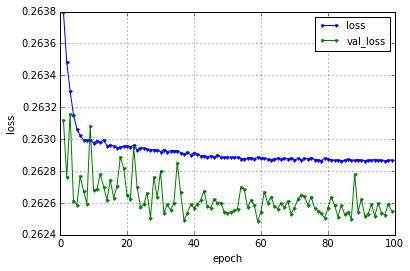

In [72]:
# plot loss
loss = hist_vae.history['loss']
val_loss = hist_vae.history['val_loss']

plt.plot(range(1,nb_epoch), loss[1:], marker='.', label='loss')
plt.plot(range(1,nb_epoch), val_loss[1:], marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

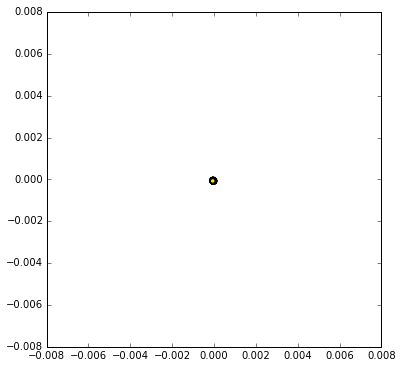

In [73]:
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:,0],X_test_encoded[:,1], c=np.argmax(y_test,axis=1))
plt.show()

In [74]:
print (X_test_encoded[:,1].shape)

(10000,)


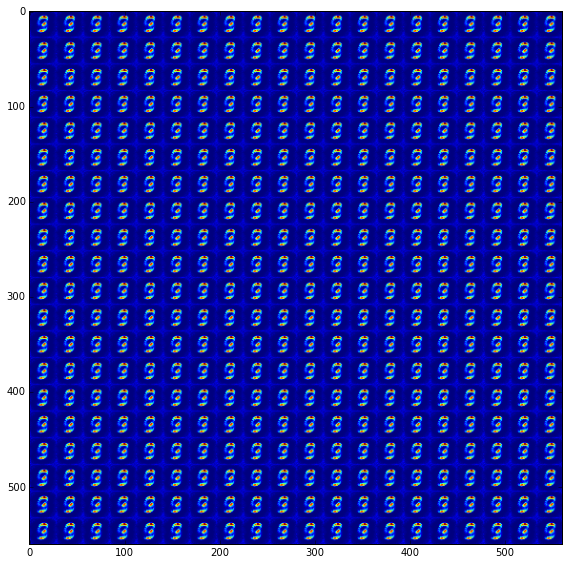

In [75]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        x_mean = decoder.predict(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean.reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()